In [1]:
import torch
import torch.nn as nn
import sys
sys.path.append('..')
import myd2l

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled(): # 判断模型是否是eval模式
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)

        if len(X.shape) == 2:
            mean = X.mean(dim=0, keepdim=True)
            var = ((X - mean) ** 2).mean(dim=0, keepdim=True)
        else:
            # 可以理解为先在整张图上取平均，再在批次维度取平均
            mean = X.mean(dim=(0, 2, 3), keepdim=True) 
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1 - momentum) * mean
        moving_var = momentum * moving_var + (1 - momentum) * var
    
    Y = gamma * X_hat + beta

    return Y, moving_mean.data, moving_var.data

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, n_features, n_dims):
        super().__init__()

        if n_dims == 2:
            shape = (1, n_features)
        else:
            shape = (1, n_features, 1, 1)
        
        # 全用广播
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)

        return Y
    

epoch  1, loss  0.7283, train acc  0.77, test acc  0.76
epoch  2, loss  0.4607, train acc  0.80, test acc  0.79
epoch  3, loss  0.4045, train acc  0.81, test acc  0.80
epoch  4, loss  0.3647, train acc  0.87, test acc  0.86
epoch  5, loss  0.3388, train acc  0.75, test acc  0.74
epoch  6, loss  0.3208, train acc  0.85, test acc  0.83
epoch  7, loss  0.3067, train acc  0.87, test acc  0.85
epoch  8, loss  0.2927, train acc  0.88, test acc  0.86
epoch  9, loss  0.2813, train acc  0.88, test acc  0.87
epoch  10, loss  0.2687, train acc  0.90, test acc  0.89


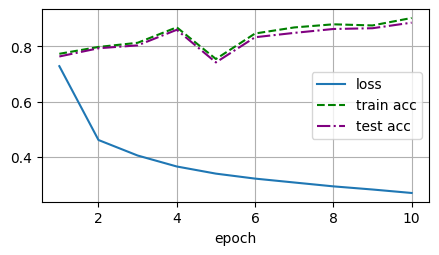

loss  0.2687, train acc  0.90, test acc  0.89
 6459630.8 examples/sec on cuda


In [4]:
# 带BN的LeNet

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, n_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, n_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), BatchNorm(120, n_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, n_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

batch_size = 256
train_iter, test_iter = myd2l.load_data_fashion_mnist(batch_size)

lr, n_epochs = 1.0, 10
device = torch.device('cuda')
myd2l.train_clf(net, n_epochs, lr, train_iter, test_iter, device)

In [8]:
net[1].weight, net[1].bias

(Parameter containing:
 tensor([3.7558, 2.2834, 2.5187, 2.0655, 3.8281, 0.3262], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-2.5840,  2.5590, -2.8997,  0.9313, -1.4107, -0.3219], device='cuda:0',
        requires_grad=True))